In [1]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from pathlib import Path

import glob
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset  # Ensure Dataset is imported
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim

import cv2
from matplotlib.image import imread

import tensorflow as tf
#from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import glob
import PIL
import random

random.seed(100)

In [2]:
breast_img_paths = glob.glob('/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png', recursive = True)
for img_path in breast_img_paths[:5]:
    print(img_path)

/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-009.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-006.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-011.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-004.png


In [4]:
# types of cancer
benign = []
malignant = []
# subtypes
A, F, PT, TA = [], [], [], [] # subtypes for benign
DC, LC, MC, PC = [], [], [], [] # subtypes for malignant

for img in breast_img_paths:
    img_name = Path(img).name
    if img_name[6] == 'A':
        A.append(img)
    elif img_name[6] == 'F':
        F.append(img)
    elif img_name[6] == 'P'and img_name[7] == 'T':
        PT.append(img)
    elif img_name[6] == 'T':
        TA.append(img)
    elif img_name[6] == 'D':
        DC.append(img)
    elif img_name[6] == 'L':
        LC.append(img)
    elif img_name[6] == 'M':
        MC.append(img)
    elif img_name[6] == 'P':
        PC.append(img)
    
    if img_name[4] == 'B':
        benign.append(img)
    else:
        malignant.append(img)
    

In [5]:
# Print the number of images in each subtype
print(f"A (Adenosis): {len(A)}")
print(f"F (Fibroadenoma): {len(F)}")
print(f"PT (Phyllodes Tumor): {len(PT)}")
print(f"TA (Tubular Adenoma): {len(TA)}")

print(f"DC (Ductal Carcinoma): {len(DC)}")
print(f"LC (Lobular Carcinoma): {len(LC)}")
print(f"MC (Mucinous Carcinoma): {len(MC)}")
print(f"PC (Papillary Carcinoma): {len(PC)}")



A (Adenosis): 444
F (Fibroadenoma): 1014
PT (Phyllodes Tumor): 453
TA (Tubular Adenoma): 569
DC (Ductal Carcinoma): 3451
LC (Lobular Carcinoma): 626
MC (Mucinous Carcinoma): 792
PC (Papillary Carcinoma): 560


In [6]:
print("Total examples: ", len(breast_img_paths))
print("Number of benign examples", len(benign))
print("Number of malignant examples", len(malignant))

Total examples:  7909
Number of benign examples 2480
Number of malignant examples 5429


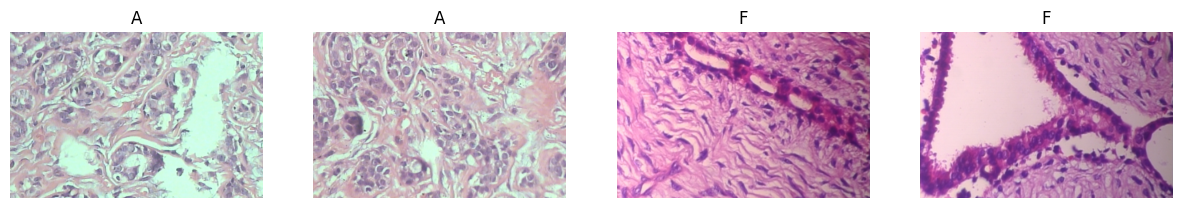

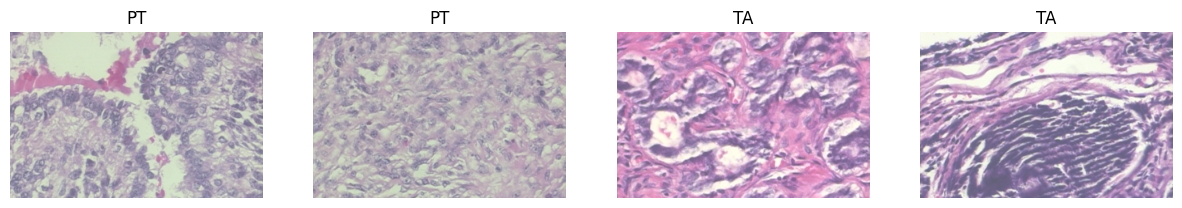

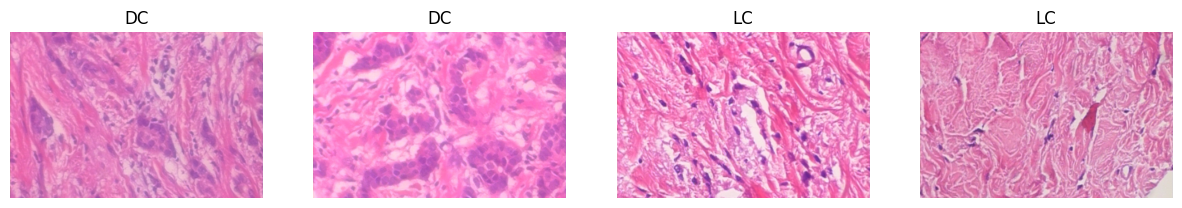

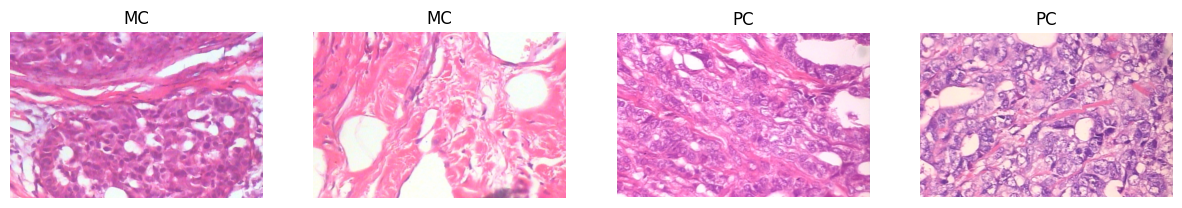

In [7]:
import matplotlib.image as mpimg

def display_images(label1, label2, list1, list2):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, img_path in zip(axes[:2], list1[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label1)  
        ax.axis('off')
    
    for ax, img_path in zip(axes[2:], list2[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label2)
        ax.axis('off')
    plt.show()

# Display images from each list
display_images("A", "F", A, F)
display_images("PT","TA", PT, TA)
display_images("DC","LC", DC, LC)
display_images("MC","PC", MC, PC)

In [8]:
def load_and_resize_images(img_list, label, size=(128, 128)):
    img_array = []
    for img in img_list:
        image = cv2.imread(img, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        image = image / 255.0
        if label != 4:
            augmented_images = augment_image(image)
            for aug_img in augmented_images:
                image_resized = tf.image.resize(aug_img, size)
                img_array.append([image_resized, label])
        else:
            image_resized = tf.image.resize(image, size)
            img_array.append([image_resized, label])

    return img_array

def augment_image(img):
    augmented_images = []

    augmented_images.append(img)

    for k in [1, 2]:
        rotated_img = tf.image.rot90(img, k=k)
        mirrored_rotated_img = tf.image.flip_left_right(rotated_img)
        augmented_images.append(mirrored_rotated_img)

    return augmented_images

A_imgs  = load_and_resize_images(A, 0)
F_imgs  = load_and_resize_images(F, 1)
PT_imgs  = load_and_resize_images(PT, 2)
TA_imgs = load_and_resize_images(TA, 3)
DC_imgs = load_and_resize_images(DC, 4)
LC_imgs = load_and_resize_images(LC, 5)
MC_imgs = load_and_resize_images(MC, 6)
PC_imgs = load_and_resize_images(PC, 7)

In [9]:
# Print the number of images in each subtype
print(f"A (Adenosis): {len(A_imgs)}")
print(f"F (Fibroadenoma): {len(F_imgs)}")
print(f"PT (Phyllodes Tumor): {len(PT_imgs)}")
print(f"TA (Tubular Adenoma): {len(TA_imgs)}")

print(f"DC (Ductal Carcinoma): {len(DC_imgs)}")
print(f"LC (Lobular Carcinoma): {len(LC_imgs)}")
print(f"MC (Mucinous Carcinoma): {len(MC_imgs)}")
print(f"PC (Papillary Carcinoma): {len(PC_imgs)}")



A (Adenosis): 1332
F (Fibroadenoma): 3042
PT (Phyllodes Tumor): 1359
TA (Tubular Adenoma): 1707
DC (Ductal Carcinoma): 3451
LC (Lobular Carcinoma): 1878
MC (Mucinous Carcinoma): 2376
PC (Papillary Carcinoma): 1680


In [10]:
data_b = A_imgs + F_imgs + PT_imgs + TA_imgs 
data_m = DC_imgs + LC_imgs + MC_imgs + PC_imgs
print("Total number of benign examples:", len(data_b))
print("Total number of malignant examples:", len(data_m))

random.shuffle(data_b)
random.shuffle(data_m)

# Initial split to separate out the test set (20% of the data)
dataTrain_b, dataTest_b = train_test_split(data_b, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (75% train, 25% val of 80% train-val data)
dataTrain_b, dataVal_b = train_test_split(dataTrain_b, test_size=0.25, random_state=42)

# Initial split to separate out the test set (20% of the data)
dataTrain_m, dataTest_m = train_test_split(data_m, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (75% train, 25% val of 80% train-val data)
dataTrain_m, dataVal_m = train_test_split(dataTrain_m, test_size=0.25, random_state=42)

dataTrain_b_modified = [(image, 0) for image, label in dataTrain_b]
dataTrain_m_modified = [(image, 1) for image, label in dataTrain_m]

dataTrain = dataTrain_b_modified + dataTrain_m_modified
random.shuffle(dataTrain)

dataVal_b_modified = [(image, 0) for image, label in dataVal_b]
dataVal_m_modified = [(image, 1) for image, label in dataVal_m]

dataVal = dataVal_b_modified + dataVal_m_modified
random.shuffle(dataVal)

dataTest_b_modified = [(image, 0) for image, label in dataTest_b]
dataTest_m_modified = [(image, 1) for image, label in dataTest_m]

dataTest = dataTest_b_modified + dataTest_m_modified

print("Total number of examples:", len(dataTrain) + len(dataVal) + len(dataTest))

Total number of benign examples: 7440
Total number of malignant examples: 9385
Total number of examples: 16825


In [11]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images)  # Convert images to numpy array
    labels = np.array(labels)
    
    # One-hot encode labels
    labels = tf.keras.utils.to_categorical(labels, num_classes=2)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

with tf.device('/GPU:0'):
    train_dataset = create_tf_dataset(dataTrain)
    val_dataset = create_tf_dataset(dataVal)
    test_dataset = create_tf_dataset(dataTest)

In [12]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the Xception base model
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

# Extract intermediate layers
# You can check `base_model.summary()` to find exact layer names
layer_names = ['block3_sepconv2_act', 'block10_sepconv2_act', 'block13_sepconv2_act']
intermediate_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create a model to output intermediate layers
intermediate_model = Model(inputs=base_model.input, outputs=intermediate_outputs)

# Define branches for each intermediate output
branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)

# Score-level fusion
fusion = Concatenate()(branch_outputs)

# Final layers
x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(2, activation='softmax')(x)

# Combine into a final model
binary_model = Model(inputs=base_model.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)

binary_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Print model summary
binary_model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 14,713,538 (56.13 MB)

 Trainable params: 14,669,858 (55.96 MB)

 Non-trainable params: 43,680 (170.62 KB)

In [14]:
import time

start_time = time.time()

history = binary_model.fit(train_dataset,
                           validation_data=val_dataset,
                           epochs=50,
                           callbacks=[early_stopping, reduce_lr])

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 95s 327ms/step - accuracy: 0.6993 - loss: 1.1120 - val_accuracy: 0.7474 - val_loss: 0.9759 - learning_rate: 1.0000e-04
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 173ms/step - accuracy: 0.9018 - loss: 0.5800 - val_accuracy: 0.9251 - val_loss: 0.7354 - learning_rate: 1.0000e-04
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 174ms/step - accuracy: 0.9555 - loss: 0.4515 - val_accuracy: 0.9492 - val_loss: 0.5146 - learning_rate: 1.0000e-04
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 173ms/step - accuracy: 0.9790 - loss: 0.3879 - val_accuracy: 0.9533 - val_loss: 0.4456 - learning_rate: 1.0000e-04
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 173ms/step - accuracy: 0.9845 - loss: 0.3584 - val_accuracy: 0.9640 - val_loss: 0.4037 - learning_rate: 1.0000e-04
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 173ms/step - accuracy: 0.9927 - loss: 0.3287 - val_accuracy: 0.9593 - val_loss: 0.4173 - learning_rate: 1.0000e-04
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 17

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


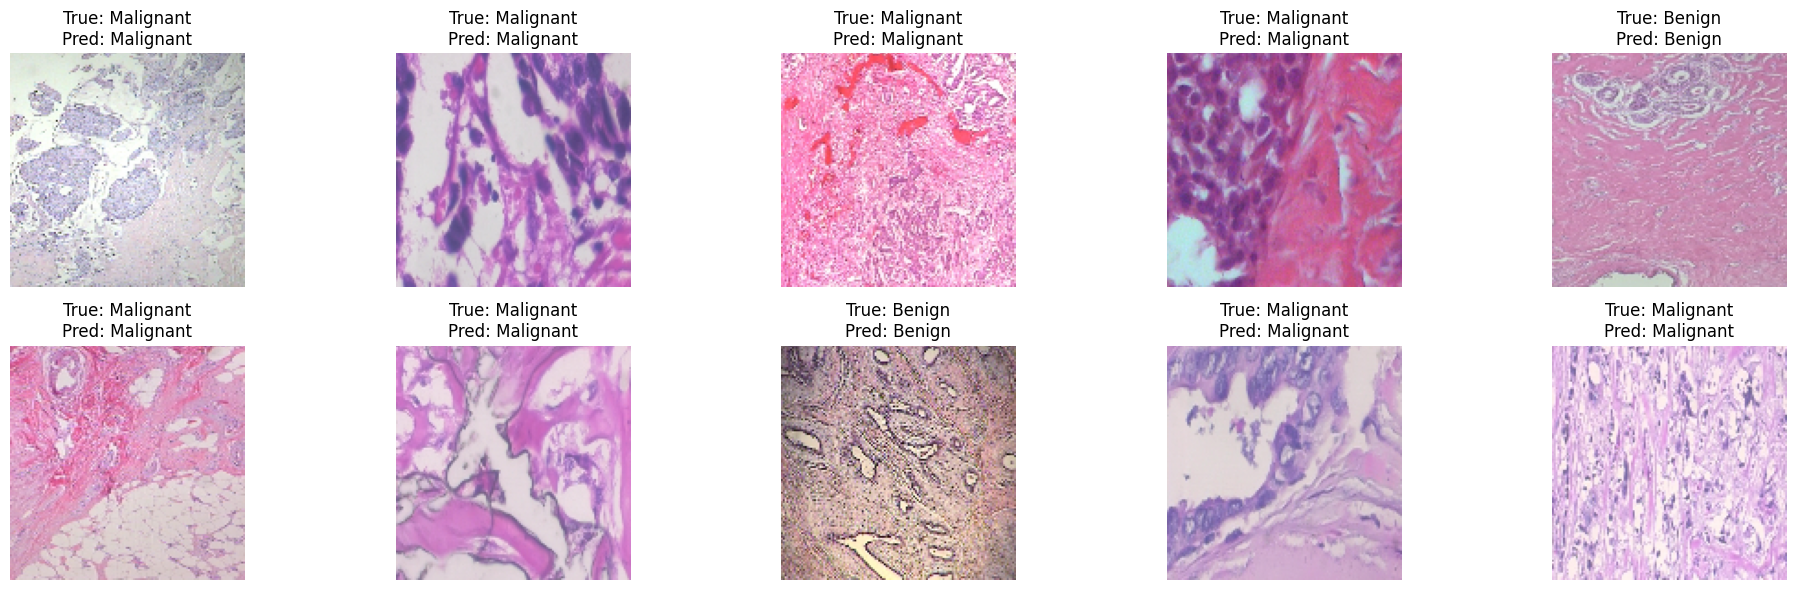

In [15]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import numpy as np

# Randomly select 10 test samples
random_indices = random.sample(range(len(dataTest)), 10)
random_images = [dataTest[i][0] for i in random_indices]
true_labels = [dataTest[i][1] for i in random_indices]

# Stack them into a batch
image_batch = tf.stack(random_images)
predictions = binary_model.predict(image_batch)

# Get predicted labels
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Label mapping
label_map = {0: "Benign", 1: "Malignant"}

# Plot the results
plt.figure(figsize=(20, 6))
for i in range(10):
    img = image_batch[i].numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in valid range

    plt.subplot(2, 5, i + 1)  # Arrange in 2 rows and 5 columns
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {label_map[true_labels[i]]}\nPred: {label_map[predicted_labels[i]]}")
plt.tight_layout()
plt.show()


In [16]:
train_loss, train_acc = binary_model.evaluate(train_dataset)
print(f"Train accuracy (binary classification): {train_acc}")
test_loss, test_acc = binary_model.evaluate(test_dataset)
print(f"Test accuracy (binary classification): {test_acc}")

158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 1.0000 - loss: 0.0594
Train accuracy (binary classification): 1.0
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9844 - loss: 0.1258
Test accuracy (binary classification): 0.983060896396637


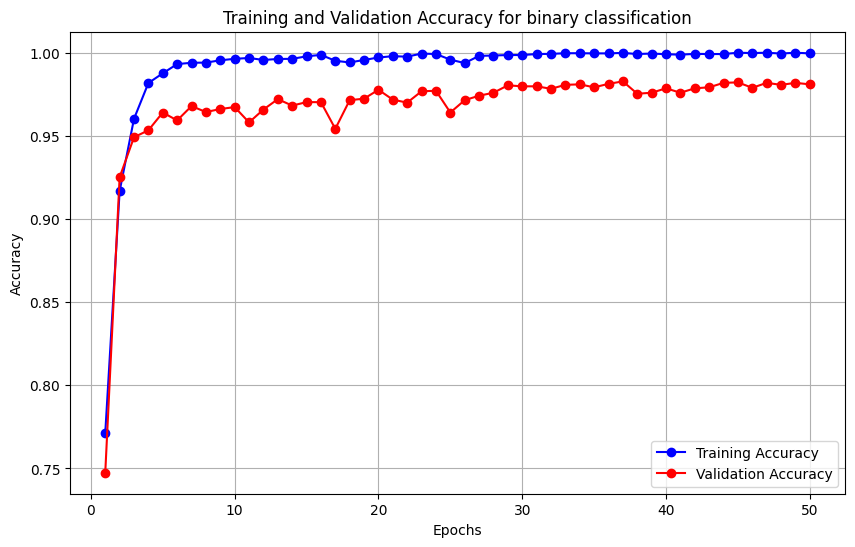

In [17]:
import matplotlib.pyplot as plt

# Extract accuracy data from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a list of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for binary classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
y_true = []
y_pred = []

for images, labels in test_dataset:
    # Predict the classes for each image
    predictions = binary_model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1) 
    true_classes = np.argmax(labels, axis=1)

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute precision, recall, and F1 score for multi-class classification
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9846
Recall: 0.9851
F1 Score: 0.9848


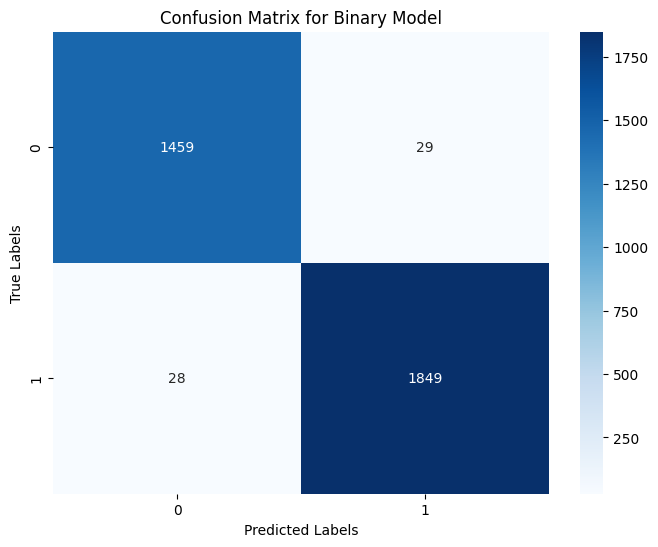

In [19]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Binary Model')
plt.show()

In [22]:
dataTrain_m = [(image, label-4) for image, label in dataTrain_m]
dataVal_m = [(image, label-4) for image, label in dataVal_m]
dataTest_m = [(image, label-4) for image, label in dataTest_m]

In [23]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images)  # Convert images to numpy array
    labels = np.array(labels)
    
    # One-hot encode labels
    labels = tf.keras.utils.to_categorical(labels, num_classes=4)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

dataTrain_b = create_tf_dataset(dataTrain_b)
dataVal_b = create_tf_dataset(dataVal_b)
test_dataset_b = create_tf_dataset(dataTest_b)
dataTrain_m = create_tf_dataset(dataTrain_m)
dataVal_m = create_tf_dataset(dataVal_m)
test_dataset_m = create_tf_dataset(dataTest_m)

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Benign Subtypes Model using Xception
base_model_b = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

# Extract intermediate layers from Xception
layer_names = ['block3_sepconv2_act', 'block10_sepconv2_act', 'block13_sepconv2_act']
intermediate_outputs = [base_model_b.get_layer(name).output for name in layer_names]

# Create intermediate model (optional - not used further here, can help for debugging)
intermediate_model = Model(inputs=base_model_b.input, outputs=intermediate_outputs)

# Define the branches for each intermediate output
branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)

# Concatenate the branch outputs
fusion = Concatenate()(branch_outputs)

# Final dense layers
x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(4, activation='softmax')(x)  # 4 classes for benign subtypes

# Final model
benign_model = Model(inputs=base_model_b.input, outputs=final_output)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
benign_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Print summary (optional)
benign_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 14,713,572 (56.13 MB)

 Trainable params: 14,669,892 (55.96 MB)

 Non-trainable params: 43,680 (170.62 KB)

In [25]:
import time

start_time = time.time()

history_b = benign_model.fit(dataTrain_b,
                    validation_data=dataVal_b,
                    epochs=50)

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 71s 520ms/step - accuracy: 0.3555 - loss: 2.0570 - val_accuracy: 0.2023 - val_loss: 1.7334
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.6306 - loss: 1.2521 - val_accuracy: 0.2050 - val_loss: 1.6988
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.7674 - loss: 0.9592 - val_accuracy: 0.3091 - val_loss: 1.6148
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.8591 - loss: 0.7869 - val_accuracy: 0.4805 - val_loss: 1.4936
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.8970 - loss: 0.6903 - val_accuracy: 0.6613 - val_loss: 1.3247
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.9267 - loss: 0.6184 - val_accuracy: 0.8085 - val_loss: 1.1239
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.9489 - loss: 0.5604 - val_accuracy: 0.8555 - val_loss: 0.9290
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.9534 - loss: 0.5308 - val_accu

In [26]:
train_loss, train_acc = benign_model.evaluate(dataTrain_b )
print(f"Train accuracy -multi class for benign-: {train_acc:.4f}")
test_loss, test_acc = benign_model.evaluate(test_dataset_b)
print(f"Test accuracy -multi class for benign-: {test_acc:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9995 - loss: 0.1582
Train accuracy -multi class for benign-: 0.9998
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9051 - loss: 0.5200
Test accuracy -multi class for benign-: 0.9153


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


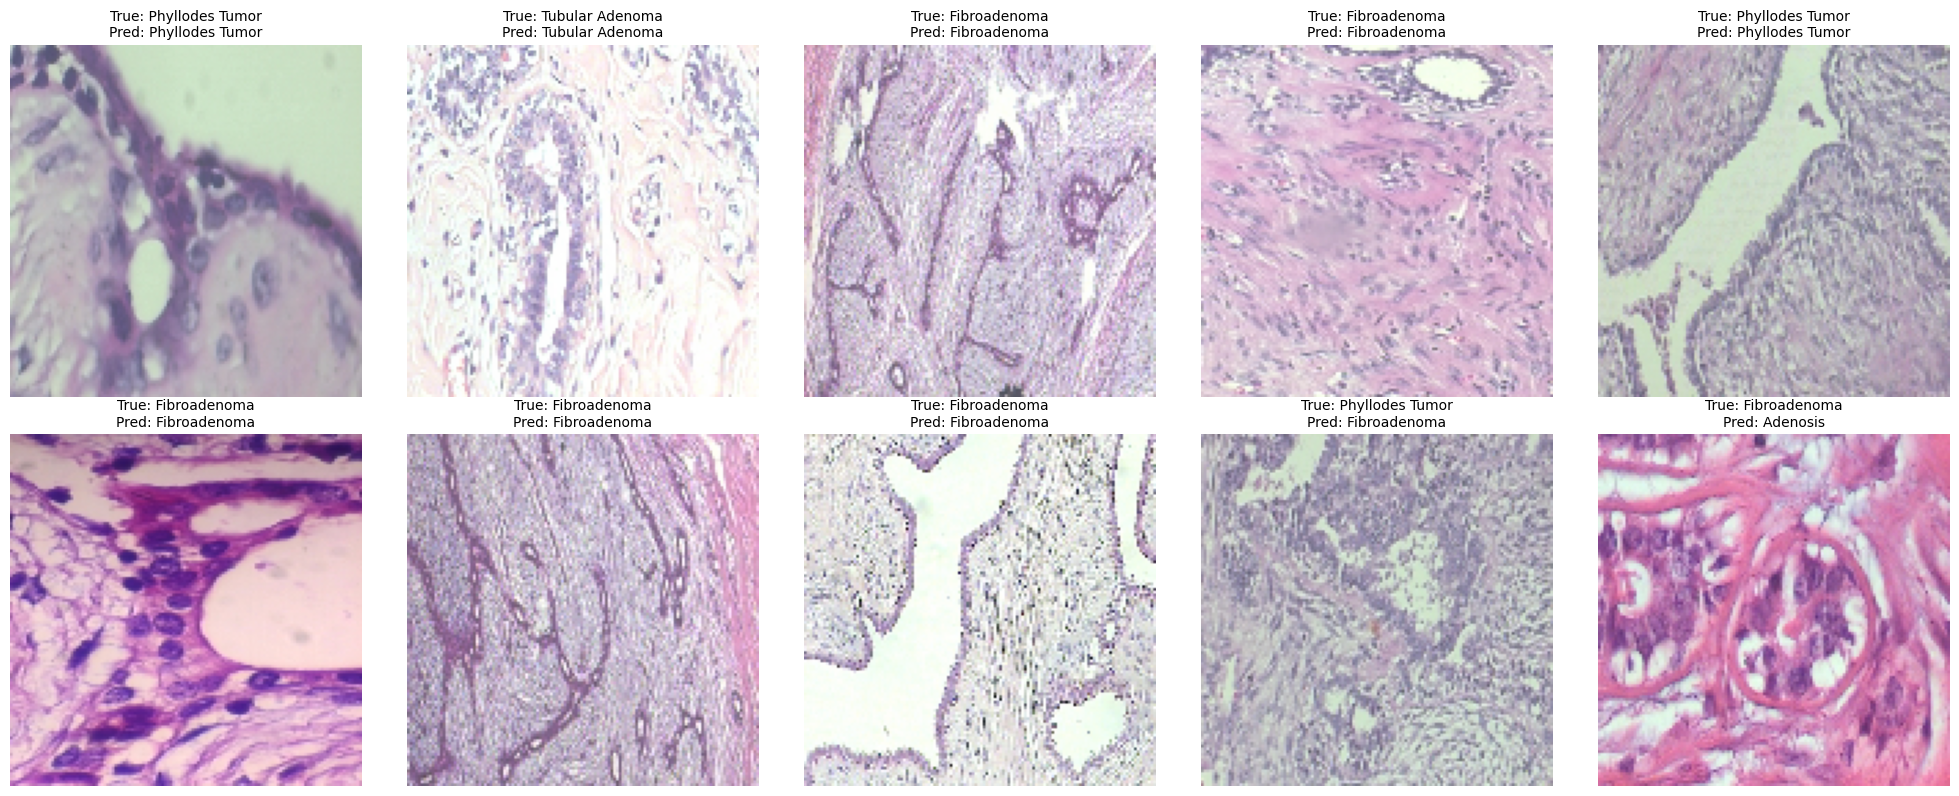

In [27]:
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

# Randomly select 10 test samples
random_indices = random.sample(range(len(dataTest_b)), 10)
random_images = [dataTest_b[i][0] for i in random_indices]
true_labels = [dataTest_b[i][1] for i in random_indices]

# Stack them into a batch
image_batch = tf.stack(random_images)
predictions = benign_model.predict(image_batch)

# Get predicted labels
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Label mapping
label_map = {0: "Adenosis", 1: "Fibroadenoma", 2: "Phyllodes Tumor", 3: "Tubular Adenoma"}

# Plot the results for 10 images (2 rows x 5 columns)
plt.figure(figsize=(20, 8))
for i in range(10):
    img = image_batch[i].numpy()
    img = np.clip(img, 0, 1)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {label_map[true_labels[i]]}\nPred: {label_map[predicted_labels[i]]}", fontsize=10)

plt.tight_layout()
plt.show()

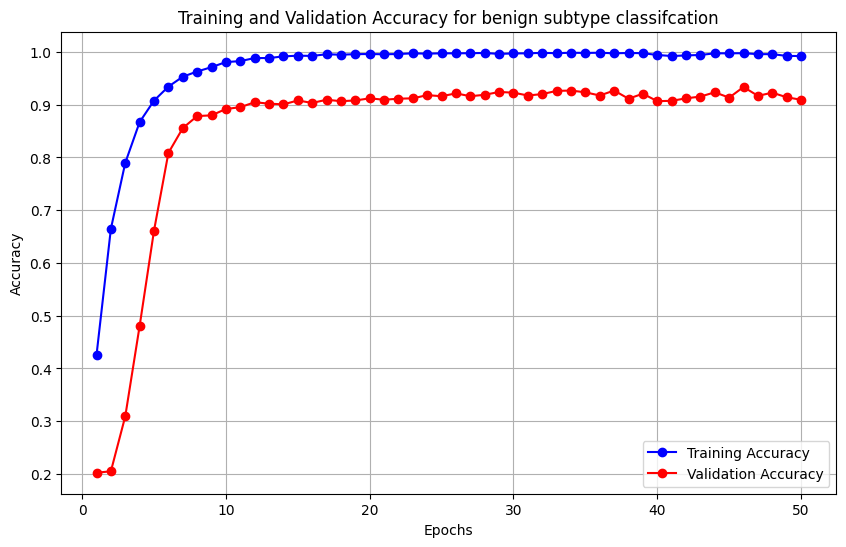

In [28]:
import matplotlib.pyplot as plt

# Extract accuracy data from the history object
train_acc = history_b.history['accuracy']
val_acc = history_b.history['val_accuracy']

# Create a list of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for benign subtype classifcation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
y_true_b = []
y_pred_b = []

for images, labels in test_dataset_b:  
    # Predict the classes for each image
    predictions_b = benign_model.predict(images, verbose=0)
    predicted_classes_b = np.argmax(predictions_b, axis=1) 
    true_classes_b = np.argmax(labels, axis=1) 

    y_true_b.extend(true_classes_b)
    y_pred_b.extend(predicted_classes_b)

y_true_b = np.array(y_true_b)
y_pred_b = np.array(y_pred_b)

precision = precision_score(y_true_b, y_pred_b, average='macro')
recall = recall_score(y_true_b, y_pred_b, average='macro')
f1 = f1_score(y_true_b, y_pred_b, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9259
Recall: 0.8927
F1 Score: 0.9068


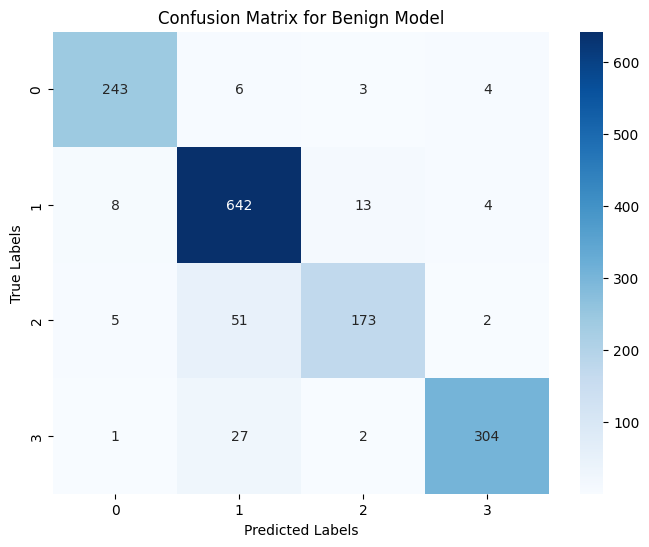

In [30]:
conf_matrix_b = confusion_matrix(y_true_b, y_pred_b)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_b, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Benign Model')
plt.show()

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Malignant Subtypes Model using Xception
base_model_m = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

# Extract intermediate layers from Xception
layer_names = ['block3_sepconv2_act', 'block10_sepconv2_act', 'block13_sepconv2_act']
intermediate_outputs = [base_model_m.get_layer(name).output for name in layer_names]

# Create intermediate model (optional - for visualization/debugging)
intermediate_model = Model(inputs=base_model_m.input, outputs=intermediate_outputs)

# Define the branches for each intermediate output
branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)

# Concatenate the branch outputs for score-level fusion
fusion = Concatenate()(branch_outputs)

# Final dense layers
x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(4, activation='softmax')(x)  # 4 classes for malignant subtypes

# Combine everything into a model
malignant_model = Model(inputs=base_model_m.input, outputs=final_output)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
malignant_model.compile(optimizer=optimizer,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Optional: model summary
malignant_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 14,713,572 (56.13 MB)

 Trainable params: 14,669,892 (55.96 MB)

 Non-trainable params: 43,680 (170.62 KB)

In [ ]:
import time

start_time = time.time()

history_m = malignant_model.fit(dataTrain_m,
                                validation_data=dataVal_m,
                                epochs=50)

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 448ms/step - accuracy: 0.3583 - loss: 2.0451 - val_accuracy: 0.2808 - val_loss: 1.7380
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.6465 - loss: 1.2256 - val_accuracy: 0.4262 - val_loss: 1.6497
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.7512 - loss: 0.9630 - val_accuracy: 0.6052 - val_loss: 1.4992
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.8445 - loss: 0.7978 - val_accuracy: 0.8023 - val_loss: 1.2748
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.8864 - loss: 0.6976 - val_accuracy: 0.8450 - val_loss: 1.0749
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.9213 - loss: 0.6236 - val_accuracy: 0.8546 - val_loss: 0.9021
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.9414 - loss: 0.5684 - val_accuracy: 0.8615 - val_loss: 0.7796
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.9551 - loss: 0.5247 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


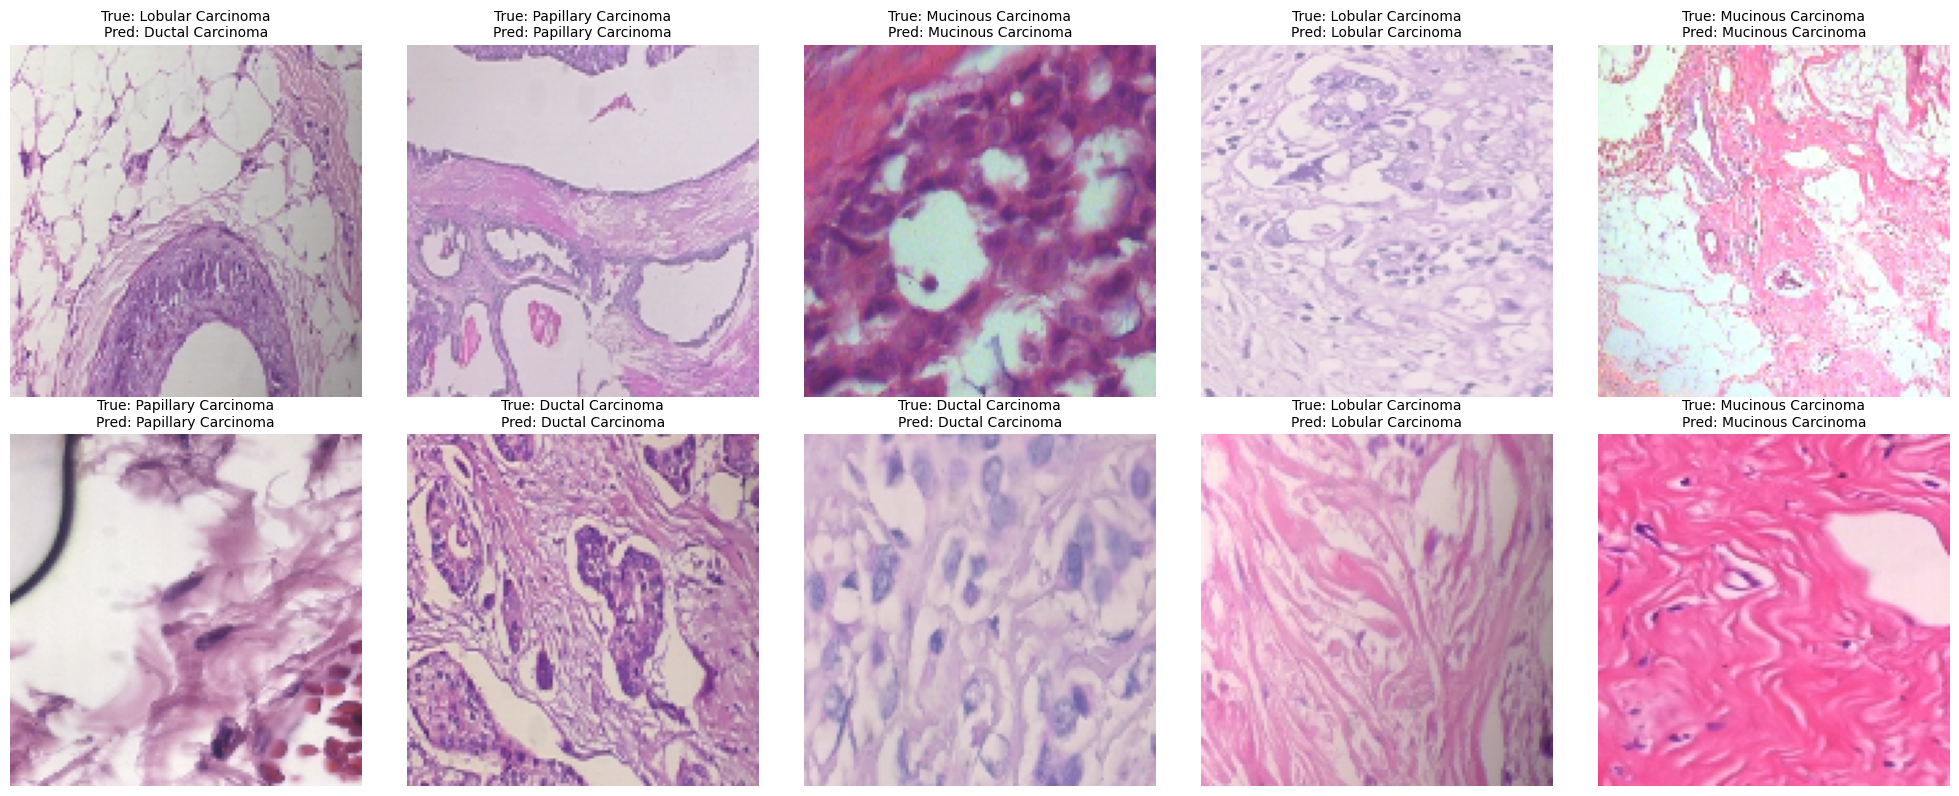

In [35]:
# Stack images
image_batch = tf.stack(random_images)

# Handle labels
stacked_labels = tf.stack(true_labels).numpy()
if stacked_labels.ndim == 1:
    true_labels = stacked_labels
else:
    true_labels = np.argmax(stacked_labels, axis=1)

# Predict
predictions = malignant_model.predict(image_batch)
predicted_labels = tf.argmax(predictions, axis=1).numpy()


label_map = {0: "Ductal Carcinoma", 1: "Lobular Carcinoma", 2: "Mucinous Carcinoma", 3: "Papillary Carcinoma"}

# Plot
plt.figure(figsize=(20, 8))
for i in range(10):
    img = image_batch[i].numpy()
    img = np.clip(img, 0, 1)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {label_map[true_labels[i]]}\nPred: {label_map[predicted_labels[i]]}", fontsize=10)

plt.tight_layout()
plt.show()


In [36]:
train_loss, train_acc = malignant_model.evaluate(dataTrain_m )
print(f"Train accuracy -multi class for malignant-: {train_acc:.4f}")
test_loss, test_acc = malignant_model.evaluate(test_dataset_m)
print(f"Test accuracy -multi class for malignant-: {test_acc:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9919 - loss: 0.1372
Train accuracy -multi class for malignant-: 0.9922
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9147 - loss: 0.4630
Test accuracy -multi class for malignant-: 0.9217


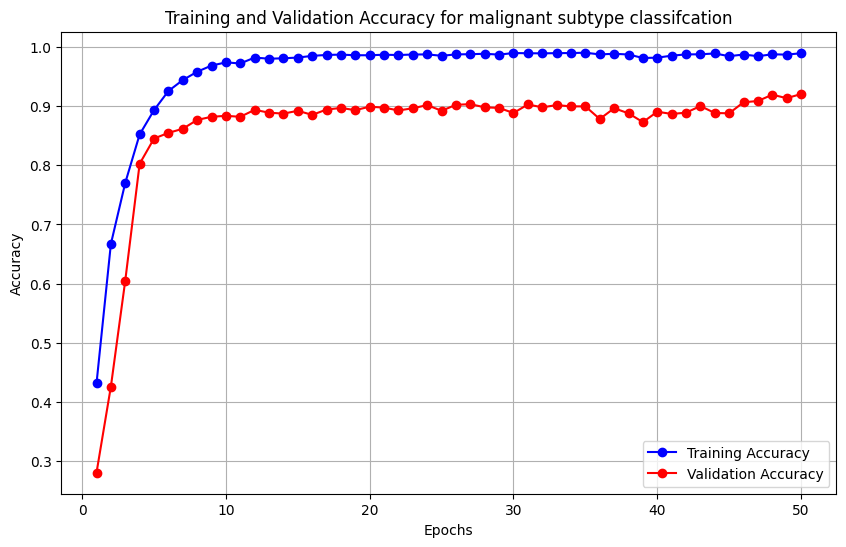

In [37]:
import matplotlib.pyplot as plt

# Extract accuracy data from the history object
train_acc = history_m.history['accuracy']
val_acc = history_m.history['val_accuracy']

# Create a list of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for malignant subtype classifcation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
y_true_m = []
y_pred_m = []

for images, labels in test_dataset_m:  
    # Predict the classes for each image
    predictions_m = malignant_model.predict(images, verbose=0)
    predicted_classes_m = np.argmax(predictions_m, axis=1)
    true_classes_m = np.argmax(labels, axis=1)

    y_true_m.extend(true_classes_m)
    y_pred_m.extend(predicted_classes_m)

y_true_m = np.array(y_true_m)
y_pred_m = np.array(y_pred_m)

# Compute precision, recall, and F1 score for multi-class classification
precision = precision_score(y_true_m, y_pred_m, average='macro')
recall = recall_score(y_true_m, y_pred_m, average='macro')
f1 = f1_score(y_true_m, y_pred_m, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9223
Recall: 0.9225
F1 Score: 0.9223


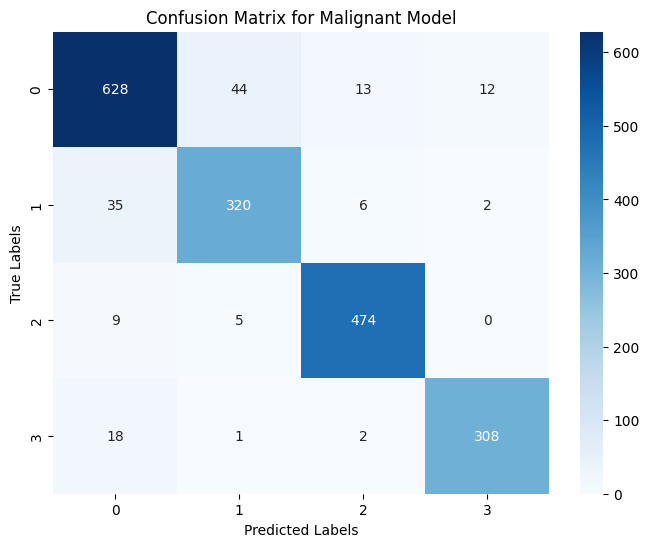

In [39]:
conf_matrix_m = confusion_matrix(y_true_m, y_pred_m)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_m, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Malignant Model')
plt.show()